In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class vertex:
    def __init__(self,x,y, inci_edge = None, name = None, typ = None):
        self.x = x
        self.y = y
        self.name = name
        self.inci_edge = inci_edge
        self.typ = typ
    
    def __repr__(self):
        return f'({self.x},{self.y})'
    
    def __str__(self):
        return self.name
    
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    
    def __lt__(self, other):
        return self.y > other.y or (self.y == other.y and self.x < other.x)
    
    def cross_prod(self, orig, obj):
        return (obj.x - orig.x)*(self.y-orig.y)-(obj.y-orig.y)*(self.x-orig.x)
    
    def chain(self, face):
        siguiente = self.inci_edge
        while siguiente.inci_face != face:
            if siguiente.ini ==  self:
                siguiente = siguiente.prev_e
            else:
                siguiente = siguiente.twin
        siguiente = siguiente.fin
        anterior = self.inci_edge.prev_e
        while anterior.inci_face != face:
            if anterior.fin ==  self:
                anterior = anterior.next_e
            else:
                anterior = anterior.twin
        anterior = anterior.ini        
        if siguiente < self and self < anterior:
            return 'Right'
        else:
            return 'Left'

In [3]:
  class semi_edge:
    def __init__(self, v1, v2, twin = None, next_e = None, prev_e = None, inci_face = None, name = None):
        self.ini = v1
        self.fin = v2
        self.twin = twin
        self.next_e = next_e
        self.prev_e = prev_e
        self.name = name
        self.inci_face = inci_face
    
    def __repr__(self):
        return f'{self.ini} ---> {self.fin}'
                 
    def __str__(self):
        return self.name
    
    def __eq__(self, other):
        return (self.ini == other.ini) and (self.fin == other.fin)
    
    def __hash__(self):
        return hash((self.ini, self.fin))

In [4]:
class edge:
    def __init__(self, v1, v2, next_e = None, prev_e = None, name = None):
        self.ini = v1
        self.fin = v2
        self.next_e = next_e
        self.prev_e = prev_e
        self.name = name
    
    def __repr__(self):
        return f'{self.ini} ---> {self.fin}'
                 
    def __str__(self):
        return self.name
    
    def __eq__(self, other):
        return (self.ini == other.ini) and (self.fin == other.fin)
    
    def middle(self, y_new):
        alpha = (y_new - self.fin.y)/(self.ini.y - self.fin.y)
        x_new = self.fin.x + alpha*(self.ini.x - self.fin.x)
        return [round(x_new,4), y_new]

In [5]:
class face:
    def __init__(self, name, s_e = [], v = [], side = 'Unknown'):
        self.name = name
        self.s_e = s_e
        self.v = v
        self.side = side
        
    def __repr__(self):
        return f'{self.s_e}'
    
    def __str__(self):
        return self.name
    
    def define(self):
        mn = min(self.v)
        for e in self.s_e:
            if e.ini == mn:
                nex = e.fin
            elif e.fin == mn:
                pre = e.ini
        turn = nex.cross_prod(pre, mn) # Se usa la definicion de rotacion cambiando el uso del giro
        if turn > 0:
            self.side = 'Exterior'
        elif turn < 0:
            self.side = 'Interior'
        
    def plot(self):
        xcoord = [v.x for v in self.v]
        ycoord = [v.y for v in self.v]
        plt.scatter(xcoord,ycoord)
        for v in self.v:
            plt.annotate(v.name, (v.x,v.y))
        for e in self.s_e:
            plt.arrow(e.ini.x, e.ini.y, e.fin.x-e.ini.x, e.fin.y-e.ini.y, head_width=0.25)
        plt.show()

In [6]:
def to_vert(lt):
    return [vertex(x[0], x[1], name = f'v{i}') for i,x in enumerate(lt)]

def build_simple_se(lv):
    aux = lv.copy()
    aux.append(aux.pop(0))
    aux = [*zip(lv, aux)]
    aux2 = []
    for i in range(len(aux)):
        aux2.extend([semi_edge(aux[i][0], aux[i][1], name = f'e{i}0'),\
                     semi_edge(aux[i][1], aux[i][0], name = f'e{i}1')])
    for i in range(-2,len(aux2)-2,2):
        aux2[i].twin = aux2[i+1]
        aux2[i+1].twin = aux2[i]
        
        aux2[i].next_e = aux2[i+2]
        aux2[i+1].next_e = aux2[i-1]
        
        aux2[i].prev_e = aux2[i-2]
        aux2[i+1].prev_e = aux2[i+3]
        
        lv[i//2].inci_edge = aux2[i]
    return aux2

def build_simple_e(lv):
    lv.reverse()
    aux = lv.copy()
    aux.append(aux.pop(0))
    aux = [*zip(lv, aux)]
    aux = [edge(x[0], x[1], name = f'e{i}') for i,x in enumerate(aux)]
    for i in range(-1,len(aux)-1):      
        aux[i].next_e = aux[i+1]
        aux[i].prev_e = aux[i-1]
        lv[i].inci_edge = aux[i]
    return aux

In [7]:
class dc_edge_list:
    def __init__(self, lv, lse):
        self.v = lv        
        self.s_e = lse
        self.f = []
        self.faces()
            
    def faces(self):
        count = 0;
        for i in range(len(self.s_e)):
            initial = self.s_e[i]
            if initial.inci_face is None:
                h = face(f'h{count}', s_e = [initial], v = [initial.fin])
                initial.inci_face = h
                self.f.append(h)
                count += 1
                current = initial.next_e
                while True:
                    current.inci_face = h
                    h.s_e.append(current)
                    h.v.append(current.fin)
                    if current.next_e == initial:
                        break
                    current = current.next_e
        for h in self.f:
            h.define()                 
            
    def reset_faces(self):
        self.f = []
        for e in self.s_e:
            e.inci_face = None
            
    def update(self, pv, verbose = False):
        pv = [x for x in self.v if  x in pv]
        new_e = [semi_edge(pv[0], pv[1], name=f'e{int(self.s_e[-1].name[1:-1])+1}0'),\
                semi_edge(pv[1], pv[0], name=f'e{int(self.s_e[-1].name[1:-1])+1}1')]
        new_e[0].twin = new_e[1]
        new_e[1].twin = new_e[0]
        
        if verbose:
            print('aristas creadas')
            print(new_e)
        
        aux_a = [pv[0].inci_edge]
        current = pv[0].inci_edge.twin
        while current != aux_a[0]:
            if verbose:
                print(f'Revisando {current}')
            if current.ini == pv[0] and current.inci_face.side == 'Exterior':
                aux_a.append(current)
                current = current.twin
            else:
                current = current.next_e
        if verbose:
            print('Candidatos de a')
            print(aux_a)
        aux_b = [pv[1].inci_edge]
        current = pv[1].inci_edge.twin
        while current != aux_b[0]:
            if verbose:
                print(f'Revisando {current}')
            if current.ini == pv[1] and current.inci_face.side == 'Exterior':
                aux_b.append(current)
                current = current.twin
            else:
                current = current.next_e
        if verbose:
            print('Candidatos de b')
            print(aux_b)
        for a in aux_a:
            for b in aux_b:
                if a.inci_face == b.inci_face:
                    new_a = a
                    new_b = b
                    break
        if verbose:
            print(f'a = {new_a}: {repr(new_a)}')
            print(f'b = {new_b}: {repr(new_b)}')
        
        new_a.prev_e.next_e = new_e[0]
        new_b.prev_e.next_e = new_e[1]
        new_e[0].prev_e = new_a.prev_e
        new_e[1].prev_e = new_b.prev_e
        new_e[0].next_e = new_b
        new_e[1].next_e = new_a
        new_b.prev_e = new_e[0]
        new_a.prev_e = new_e[1]
        
        self.s_e.extend(new_e)
        
        self.reset_faces()
        self.faces()
        
    def triangulate_y_mono(self, verbose = False):
        D = []
        for c in self.f:
            if c.side == 'Exterior':
                if verbose:
                    print(f'Revisando la cara {c.name}')
                    c.plot()
                aux = c.v.copy()
                aux.sort()
                S = [aux.pop(0), aux.pop(0)]
                if verbose:
                    print(f'Pila inicial: {S}')
                for i in range(len(aux)-1):
                    print(aux[i])
                    print(aux[i].chain(c))
                    print(S[-1].chain(c))
                    if aux[i].chain(c) != S[-1].chain(c):
                        if verbose:
                            print(f'{aux[i]} y {S[-1]} en cadenas distintas')
                        while len(S) > 1:
                            out = S.pop()
                            if verbose:
                                print(f'Diagonal entre {aux[i]} y {out}')
                            D.append([aux[i], out])
                        S.append(aux[i])
                    else:
                        if verbose:
                            print(f'{aux[i]} y {S[-1]} en cadenas iguales')
                        last = S.pop()
                        print('Revisar validez de giros, agregar diagonales, agregar ultimo')
                        while len(S) > 0:
                            print(f'En cadena: {aux[i].chain(c)}')
                            print(f'Pila inicial: {S}')
                            current = S[-1]
                            print(f'Revisando {current}')
                            if aux[i].chain(c) == 'Right':
                                #siguiente = aux[i].inci_edge
                                #while siguiente.inci_face != c:
                                #    if siguiente.ini ==  aux[i]:
                                #        siguiente = siguiente.prev_e
                                #    else:
                                #        siguiente = siguiente.twin
                                #siguiente = siguiente.fin
                                print(f'Anterior: {last}')
                                print(last.cross_prod(aux[i], current))
                                if last.cross_prod(aux[i], current) < 0:
                                    print(f'Diagonal valida entre {aux[i]} y {current}')
                                    last = S.pop()
                                    D.append([aux[i], current])
                                    
                                else:
                                    break
                            
                            else:
                                #anterior = aux[i].inci_edge.prev_e
                                #while anterior.inci_face != c:
                                #    if anterior.fin ==  aux[i]:
                                #        anterior = anterior.next_e
                                #    else:
                                #        anterior = anterior.twin
                                #anterior = anterior.ini
                                print(f'Anterior: {last}')
                                print(last.cross_prod(aux[i], current))
                                if last.cross_prod(aux[i], current) > 0:
                                    print(f'Diagonal valida entre {aux[i]} y {current}')
                                    last = S.pop()
                                    D.append([aux[i], current])
                                else:
                                    break
                        S.append(last)
                        S.append(aux[i])
                        print(f'Pila final: {S}')
        S.pop()
        S.pop(0)
        if verbose:
            print(f'Trazar diagonales entre {aux[-1]} y {S}')
        print(D)
        for v in D:
            print(v)
            self.update(v)
        for v in S:
            print(v)
            self.update([aux[-1],v])
                        
                    
        

    def lista(self):
        semi_edges = []
        origin = []
        twin = []
        inci_face = []
        next_e = []
        prev_e = []
        
        for i in range(len(self.s_e)):
            semi_edges.append(self.s_e[i].name)
            origin.append(self.s_e[i].ini)
            twin.append(self.s_e[i].twin)
            inci_face.append(self.s_e[i].inci_face)
            next_e.append(self.s_e[i].next_e)
            prev_e.append(self.s_e[i].prev_e)
        return pd.DataFrame.from_dict({'Semi Aristas': semi_edges, 'Origen': origin,\
                                       'Twin': twin, 'Cara incidente': inci_face,\
                                       'Next': next_e, 'Prev': prev_e})
         
    
    def plot(self):
        xcoord = [v.x for v in self.v]
        ycoord = [v.y for v in self.v]
        plt.scatter(xcoord,ycoord)
        for v in self.v:
            plt.annotate(v.name, (v.x,v.y))
        for e in self.s_e:
            plt.plot([e.ini.x, e.fin.x], [e.ini.y, e.fin.y])
        plt.show()
            


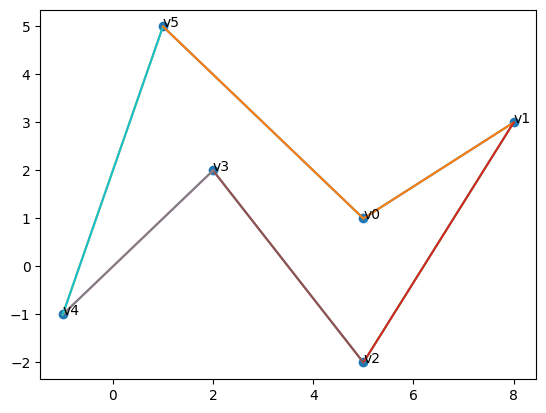

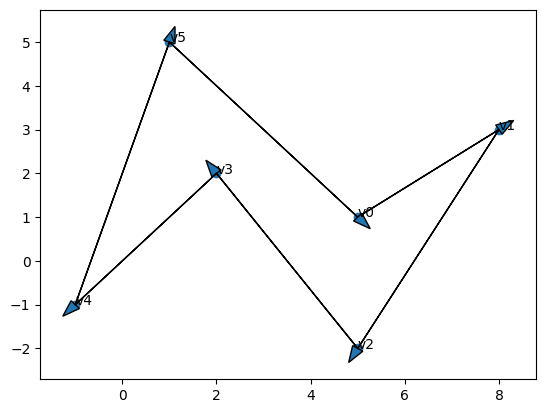

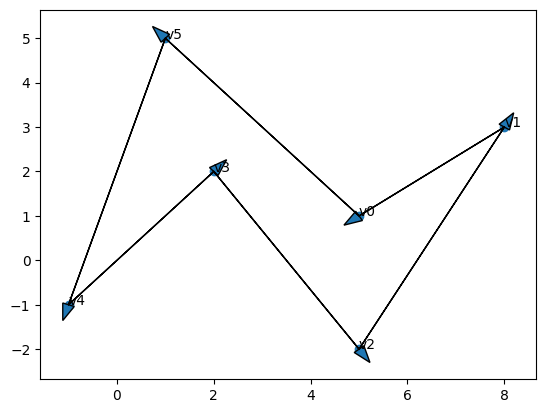

,Semi Aristas,Origen,Twin,Cara incidente,Next,Prev
0,e00,v0,e01,h0,e10,e50
1,e01,v1,e00,h1,e51,e11
2,e10,v1,e11,h0,e20,e00
3,e11,v2,e10,h1,e01,e21
4,e20,v2,e21,h0,e30,e10
5,e21,v3,e20,h1,e11,e31
6,e30,v3,e31,h0,e40,e20
7,e31,v4,e30,h1,e21,e41
8,e40,v4,e41,h0,e50,e30
9,e41,v5,e40,h1,e31,e51


In [8]:
P = [(5,1), (8,3), (5,-2), (2,2), (-1,-1), (1,5)]
lv = to_vert(P)
lse = build_simple_se(lv)

dce = dc_edge_list(lv, lse)
dce.plot()
for c in dce.f:
    c.plot()
dce.lista()

In [9]:
class edge_list:
    def __init__(self, lv, le):
        self.v = lv        
        self.edges = le
        self.classify()
                
    def classify(self):
        for v in self.v:
            for e in self.edges:
                if e.ini == v:
                    nex = e.fin
                elif e.fin == v:
                    pre = e.ini
            if v < nex and v < pre:
                turn = nex.cross_prod(pre, v)
                if turn < 0:
                    v.typ = 'Div'
                elif turn > 0:
                    v.typ = 'Ini'
            elif nex < v and pre < v:
                turn = nex.cross_prod(pre, v)
                if turn < 0:
                    v.typ = 'Mer'
                elif turn > 0:
                    v.typ = 'Fin'
            else:
                v.typ = 'Reg'
    
    def lista(self):
        edges = []
        origin = []
        next_e = []
        prev_e = []
        typ = []
        for i in range(len(self.edges)):
            edges.append(self.edges[i].name)
            origin.append(self.edges[i].ini)
            next_e.append(self.edges[i].next_e)
            prev_e.append(self.edges[i].prev_e)
        return pd.DataFrame.from_dict({'Aristas': edges, 'Origen': origin, 'Next': next_e, 'Prev': prev_e})
         
    def plot_dir(self):
        xcoord = [v.x for v in self.v]
        ycoord = [v.y for v in self.v]
        plt.scatter(xcoord,ycoord)
        for v in self.v:
            plt.annotate(v.name, (v.x,v.y))
        for e in self.edges:
            plt.arrow(e.ini.x, e.ini.y, e.fin.x-e.ini.x, e.fin.y-e.ini.y, head_width=0.25)
        plt.show()

    def plot_typ(self):
        for v in self.v:
            if v.typ == 'Div':
                plt.scatter(v.x,v.y, marker = '^', s = 100)
            elif v.typ == 'Mer':
                plt.scatter(v.x,v.y, marker = 'v', s = 100)
            elif v.typ == 'Ini':
                plt.scatter(v.x,v.y, marker = '*', s = 100)
            elif v.typ == 'Fin':
                plt.scatter(v.x,v.y, marker = 's', s = 100)
            elif v.typ == 'Reg':
                plt.scatter(v.x,v.y, s = 100)
            else:
                print('Error')
            plt.annotate(v.name, (v.x,v.y))
            
        for e in self.edges:
            plt.plot([e.ini.x, e.fin.x], [e.ini.y, e.fin.y])
        plt.show()

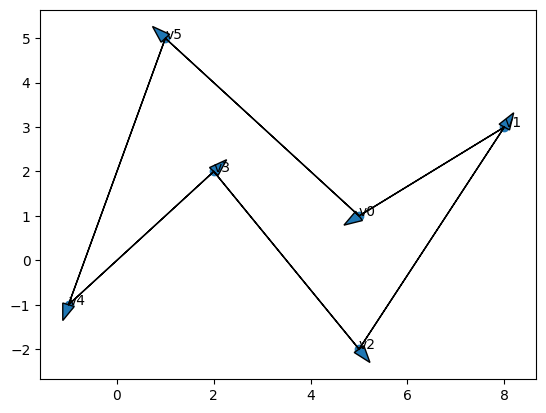

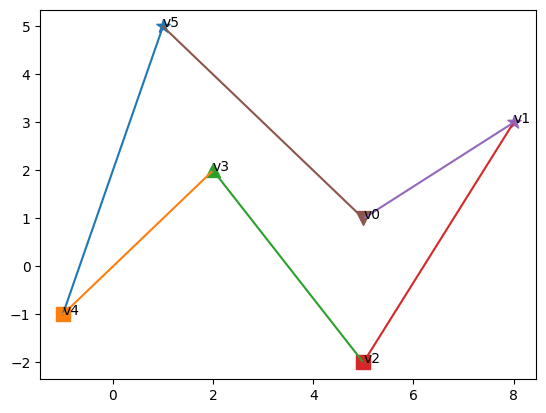

,Aristas,Origen,Next,Prev
0,e0,v5,e1,e5
1,e1,v4,e2,e0
2,e2,v3,e3,e1
3,e3,v2,e4,e2
4,e4,v1,e5,e3
5,e5,v0,e0,e4


In [10]:
P = [(5,1), (8,3), (5,-2), (2,2), (-1,-1), (1,5)]
lv = to_vert(P)
le = build_simple_e(lv)

cv = edge_list(lv, le)
cv.plot_dir()
cv.plot_typ()
cv.lista()

In [11]:
class Node:
    def __init__(self, val, helper, lc = None, rc = None, parent = None):
        self.val = val
        self.helper = helper
        self.lc = lc
        self.rc = rc
        self.parent = parent
            
def insert(root, new, helper, y, parent = None):
    if root is None:
        return Node(new, helper)
    elif new.middle(y) < root.val.middle(y):
        root.lc = insert(root.lc, new, helper, y, parent = root)
    else:
        root.rc = insert(root.rc, new, helper, y, parent = root)
    return root

def delete(root, ded):
    if root is not None:
        if ded == root.val:
            if root.rc is not None:
                if root.lc:
                    smallest = find_smallest_seg(root.rc)
                    if smallest == root.rc:
                        root.val = root.rc.val
                        root.helper = root.rc.helper
                        root.rc = root.rc.rc  
                    else:
                        new_val = smallest.val
                        new_helper = smallest.helper
                        delete(root.rc, new_val)
                        root.val = new_val
                        root.helper = new_helper
                        root.rc.parent = root
                else:
                    root.val = root.rc.val
                    root.helper = root.rc.helper
                    root.lc = root.rc.lc
                    root.rc = root.rc.rc                        
            elif root.lc != None:
                root.val = root.lc.val
                root.helper = root.lc.helper
                root.rc = root.lc.rc
                root.lc = root.lc.lc
            else:
                if not root.parent:
                    return None
        else:
            if root.lc:
                if root.lc.val == ded:
                    if root.lc.lc or root.lc.rc:
                        delete(root.lc, ded)
                    else:
                        root.lc = None
                else: 
                    delete(root.lc, ded)
            if root.rc:
                if root.rc.val == ded:
                    if root.rc.lc or root.rc.rc:
                        delete(root.rc, ded)
                    else:
                         root.rc = None
                else:
                    delete(root.rc, ded)
    return root

def find_smallest_seg(root):
    if root.lc == None:
        return root
    else:
        return find_smallest_seg(root.lc)
        
def find_left(root, v, node = None):
    if  root.val.middle(v.y)[0] < v.x :
        if root.rc:
            return find_left(root.rc, v, root)
        else:
            return root
    else:
        if node:
            if root.lc:
                return find_left(root.lc, v)
            else:
                return node
        else:
            if root.lc:
                return find_left(root.lc,v)
    
def inorder(root):
    result = [] 
    if root:
        result.extend(inorder(root.lc))
        result.append(root.val)
        result.extend(inorder(root.rc))
    return result

def find_helper(root, edge):
    if root.val == edge:
        return root.helper
    else:
        aux = None
        if root.rc != None:
            aux = find_helper(root.rc, edge)
        if not aux and root.lc != None:
            aux = find_helper(root.lc, edge)
        return aux

In [12]:
def divs_ymono(lv, le, verbose = False):
    aux = lv.copy()
    aux.sort(reverse=True)
    tau = None
    connections = []
    while len(aux) > 0:
        current = aux.pop()
        if verbose:
            print(f'Revisando {current}')
        if current.typ == 'Ini':
            tau = insert(tau, current.inci_edge, current, current.y)
        elif current.typ == 'Fin':
            if find_helper(tau, current.inci_edge.prev_e).typ == 'Mer':
                if verbose:
                    print(f'Conectar con {find_helper(tau, current.inci_edge.prev_e)}')
                connections.append([current, find_helper(tau, current.inci_edge.prev_e)])
            tau = delete(tau, current.inci_edge.prev_e)
        elif current.typ == 'Div': 
            left = find_left(tau, current)
            if verbose:
                print(f'Conectar con {left.helper}')
            connections.append([current, left.helper])
            left.helper = current
            tau = insert(tau, current.inci_edge, current, current.y)
        elif current.typ == 'Mer':
            if find_helper(tau, current.inci_edge.prev_e).typ == 'Mer':
                if verbose:
                    print(f'Conectar con {find_helper(tau, current.inci_edge.prev_e)}')
                connections.append([current, find_helper(tau, current.inci_edge.prev_e)])
            tau = delete(tau, current.inci_edge.prev_e)
            left = find_left(tau, current)
            if left.helper.typ == 'Mer':
                if verbose:
                    print(f'Conectar con {left.helper}')
                connections.append([current, left.helper])
            left.helper = current     
        elif current.typ == 'Reg':
            if current.inci_edge.prev_e.ini < current and current < current.inci_edge.fin:
                if find_helper(tau, current.inci_edge.prev_e).typ == 'Mer':
                    if verbose:
                        print(f'Conectar con {find_helper(tau, current.inci_edge.prev_e)}')
                    connections.append([current, find_helper(tau, current.inci_edge.prev_e)])
                tau = delete(tau, current.inci_edge.prev_e)
                tau = insert(tau, current.inci_edge, current, current.y)
            else:
                left = find_left(tau, current)
                if left.helper.typ == 'Mer':
                    if verbose:
                        print(f'Conectar con {left.helper}')
                    connections.append([current, left.helper])
                left.helper = current     
        else:
            print('Error')
        
        if verbose:
            print(inorder(tau))
    return connections         

In [13]:
P = [(5,1), (8,3), (5,-2), (2,2), (-1,-1), (1,5)]
lv = to_vert(P)
le = build_simple_e(lv)
cv = edge_list(lv, le)

new_edges = divs_ymono(lv, le, verbose = True)

Revisando v5
[v5 ---> v4]
Revisando v1
[v5 ---> v4, v1 ---> v0]
Revisando v3
Conectar con v5
[v5 ---> v4, v3 ---> v2, v1 ---> v0]
Revisando v0
[v5 ---> v4, v3 ---> v2]
Revisando v4
[v3 ---> v2]
Revisando v2
Conectar con v0
[]


aristas creadas
[v3 ---> v5, v5 ---> v3]
Revisando e31
Revisando e21
Revisando e20
Candidatos de a
[v3 ---> v4, v3 ---> v2]
Revisando e51
Revisando e41
Revisando e40
Candidatos de b
[v5 ---> v0, v5 ---> v4]
a = e21: v3 ---> v2
b = e41: v5 ---> v4


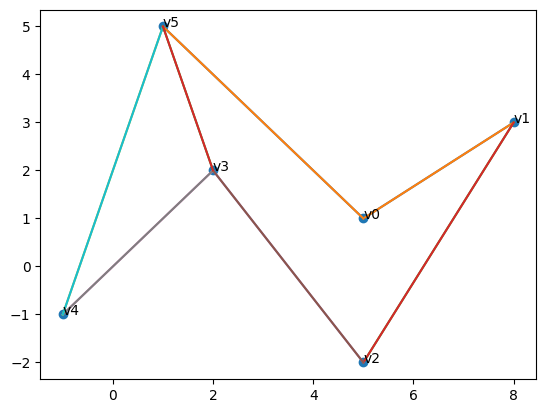

aristas creadas
[v0 ---> v2, v2 ---> v0]
Revisando e01
Revisando e51
Revisando e50
Candidatos de a
[v0 ---> v1, v0 ---> v5]
Revisando e21
Revisando e11
Revisando e10
Candidatos de b
[v2 ---> v3, v2 ---> v1]
a = e51: v0 ---> v5
b = e11: v2 ---> v1


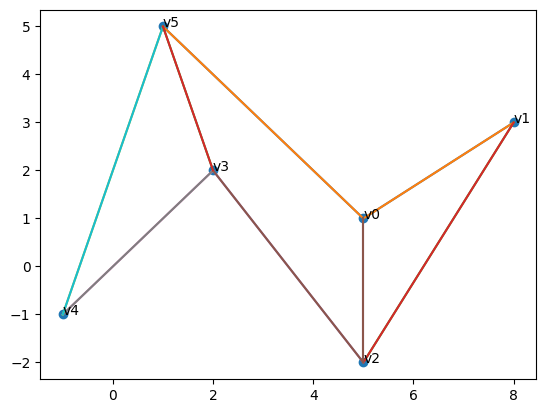

,Semi Aristas,Origen,Twin,Cara incidente,Next,Prev
0,e00,v0,e01,h0,e10,e50
1,e01,v1,e00,h1,e70,e11
2,e10,v1,e11,h0,e20,e00
3,e11,v2,e10,h1,e01,e70
4,e20,v2,e21,h0,e30,e10
5,e21,v3,e20,h2,e71,e61
6,e30,v3,e31,h0,e40,e20
7,e31,v4,e30,h3,e60,e41
8,e40,v4,e41,h0,e50,e30
9,e41,v5,e40,h3,e31,e60


In [14]:
for e in new_edges:
    dce.update(e, verbose = True)
    dce.plot()
dce.lista()

Interior
[(8,3), (5,-2), (2,2), (-1,-1), (1,5), (5,1)]


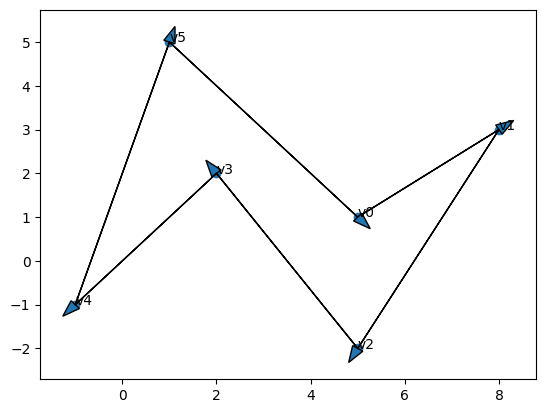

Exterior
[(5,1), (5,-2), (8,3)]


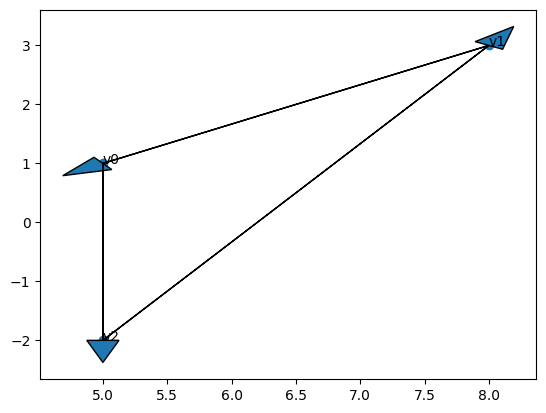

Exterior
[(5,-2), (5,1), (1,5), (2,2)]


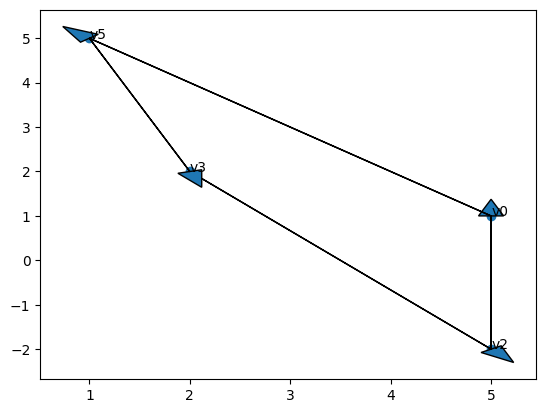

Exterior
[(2,2), (1,5), (-1,-1)]


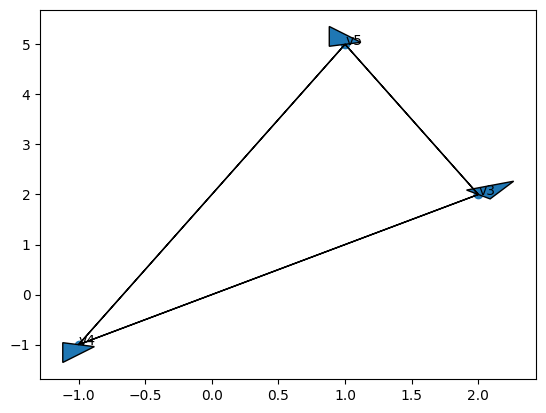

In [15]:
for c in dce.f:
    print(c.side)
    print(c.v)
    c.plot()

Revisando la cara h1


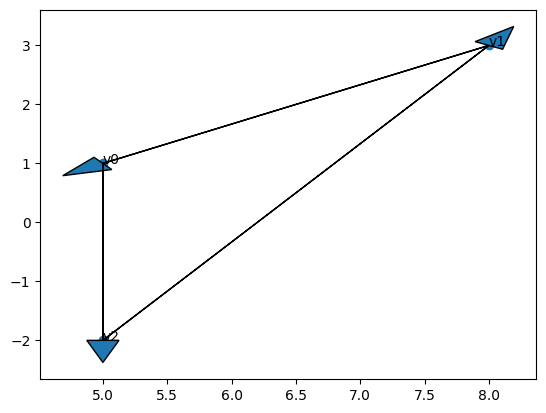

Pila inicial: [(8,3), (5,1)]
Revisando la cara h2


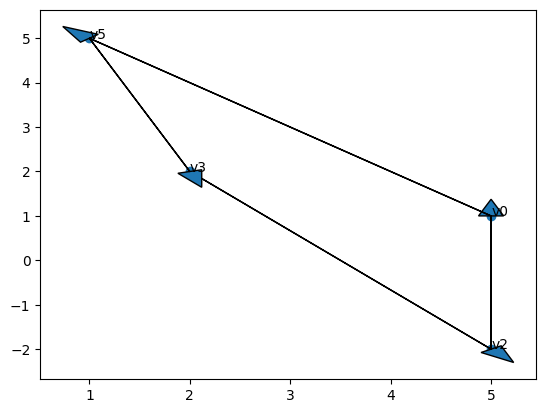

Pila inicial: [(1,5), (2,2)]
v0
Right
Left
v0 y v3 en cadenas distintas
Diagonal entre v0 y v3
Revisando la cara h3


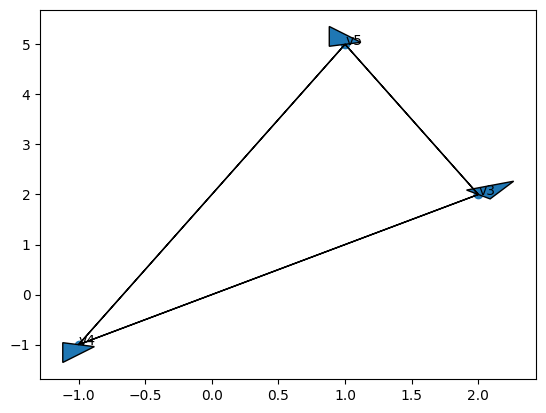

Pila inicial: [(1,5), (2,2)]
Trazar diagonales entre v4 y []
[[(5,1), (2,2)]]
[(5,1), (2,2)]


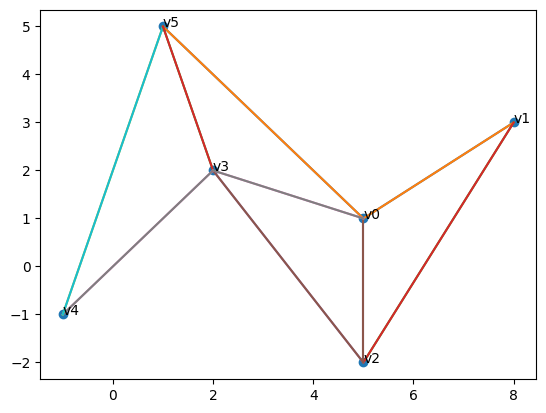

In [16]:
dce.triangulate_y_mono(verbose = True)
dce.plot()

-------------------Doble conectadas----------------------------
-------------------Clasificar vertices----------------------------
-------------------y-monotonos----------------------------


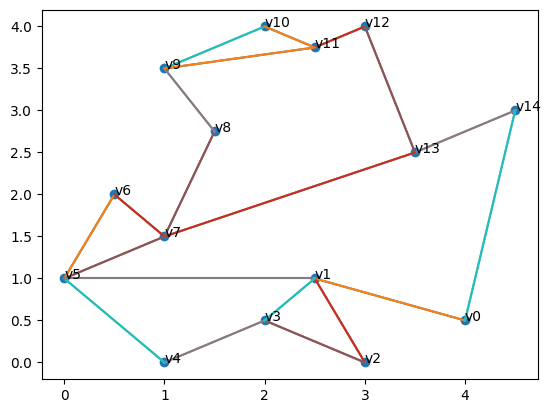

-------------------triangular----------------------------
Revisando la cara h1


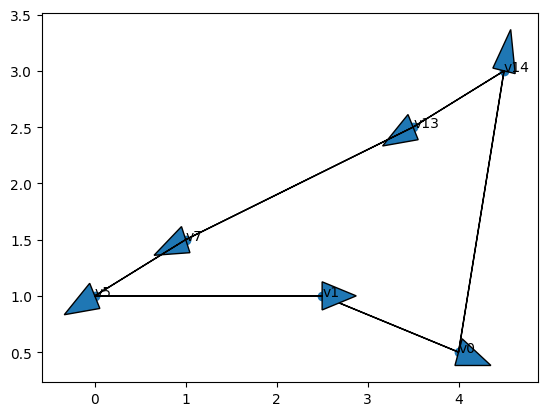

Pila inicial: [(4.5,3), (3.5,2.5)]
v7
Left
Left
v7 y v13 en cadenas iguales
Revisar validez de giros, agregar diagonales, agregar ultimo
En cadena: Left
Pila inicial: [(4.5,3)]
Revisando v14
Anterior: v13
-0.25
Pila final: [(4.5,3), (3.5,2.5), (1,1.5)]
v5
Left
Left
v5 y v7 en cadenas iguales
Revisar validez de giros, agregar diagonales, agregar ultimo
En cadena: Left
Pila inicial: [(4.5,3), (3.5,2.5)]
Revisando v13
Anterior: v7
0.25
Diagonal valida entre v5 y v13
En cadena: Left
Pila inicial: [(4.5,3)]
Revisando v14
Anterior: v13
-0.25
Pila final: [(4.5,3), (3.5,2.5), (0,1)]
v1
Left
Left
v1 y v5 en cadenas iguales
Revisar validez de giros, agregar diagonales, agregar ultimo
En cadena: Left
Pila inicial: [(4.5,3), (3.5,2.5)]
Revisando v13
Anterior: v5
3.75
Diagonal valida entre v1 y v13
En cadena: Left
Pila inicial: [(4.5,3)]
Revisando v14
Anterior: v13
1.0
Diagonal valida entre v1 y v14
Pila final: [(4.5,3), (2.5,1)]
Revisando la cara h2


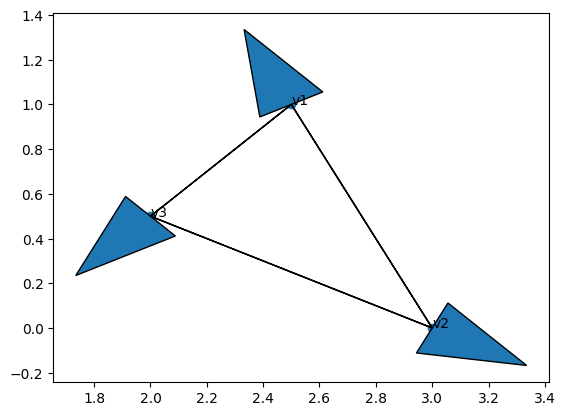

Pila inicial: [(2.5,1), (2,0.5)]
Revisando la cara h3


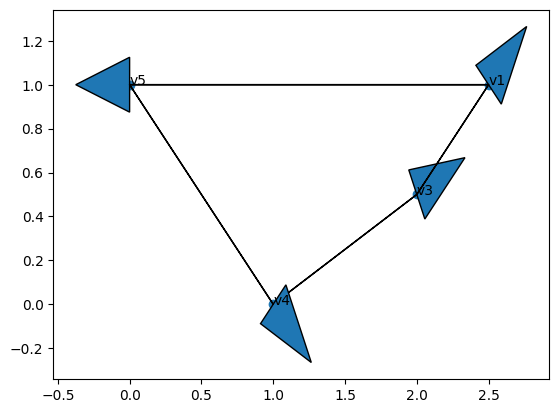

Pila inicial: [(0,1), (2.5,1)]
v3
Right
Right
v3 y v1 en cadenas iguales
Revisar validez de giros, agregar diagonales, agregar ultimo
En cadena: Right
Pila inicial: [(0,1)]
Revisando v5
Anterior: v1
-1.25
Diagonal valida entre v3 y v5
Pila final: [(0,1), (2,0.5)]
Revisando la cara h4


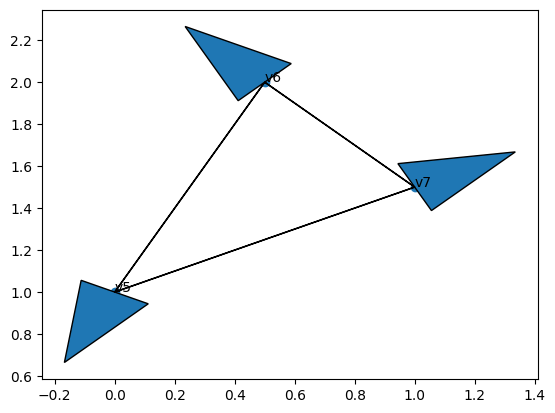

Pila inicial: [(0.5,2), (1,1.5)]
Revisando la cara h5


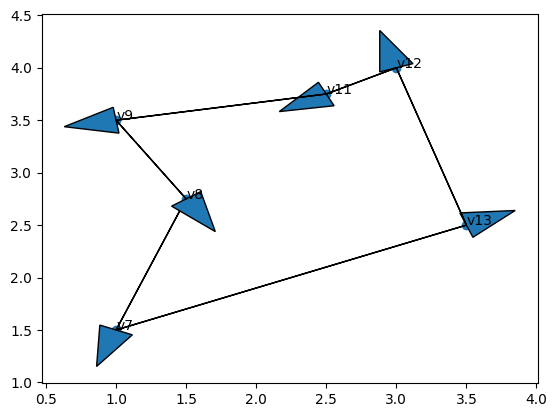

Pila inicial: [(3,4), (2.5,3.75)]
v9
Left
Left
v9 y v11 en cadenas iguales
Revisar validez de giros, agregar diagonales, agregar ultimo
En cadena: Left
Pila inicial: [(3,4)]
Revisando v12
Anterior: v11
-0.25
Pila final: [(3,4), (2.5,3.75), (1,3.5)]
v8
Left
Left
v8 y v9 en cadenas iguales
Revisar validez de giros, agregar diagonales, agregar ultimo
En cadena: Left
Pila inicial: [(3,4), (2.5,3.75)]
Revisando v11
Anterior: v9
1.25
Diagonal valida entre v8 y v11
En cadena: Left
Pila inicial: [(3,4)]
Revisando v12
Anterior: v11
0.25
Diagonal valida entre v8 y v12
Pila final: [(3,4), (1.5,2.75)]
v13
Right
Left
v13 y v8 en cadenas distintas
Diagonal entre v13 y v8
Revisando la cara h6


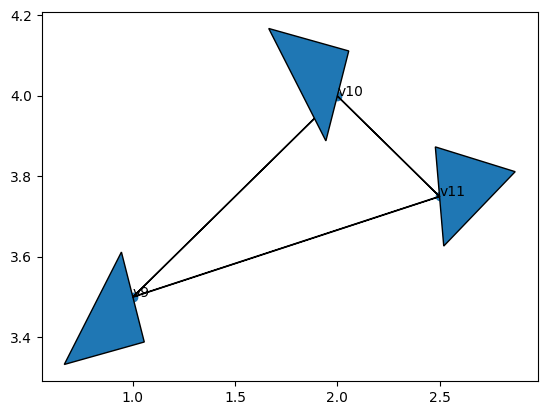

Pila inicial: [(2,4), (2.5,3.75)]
Trazar diagonales entre v9 y []
[[(0,1), (3.5,2.5)], [(2.5,1), (3.5,2.5)], [(2.5,1), (4.5,3)], [(2,0.5), (0,1)], [(1.5,2.75), (2.5,3.75)], [(1.5,2.75), (3,4)], [(3.5,2.5), (1.5,2.75)]]
[(0,1), (3.5,2.5)]
[(2.5,1), (3.5,2.5)]
[(2.5,1), (4.5,3)]
[(2,0.5), (0,1)]
[(1.5,2.75), (2.5,3.75)]
[(1.5,2.75), (3,4)]
[(3.5,2.5), (1.5,2.75)]


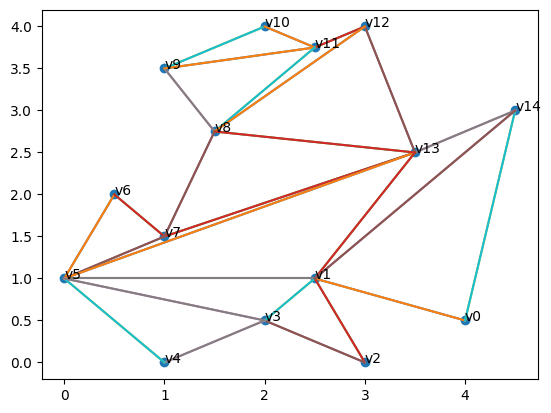

In [18]:
P = [[4.5, 3], [3.5, 2.5], [3, 4], [2.5, 3.75], [2, 4], [1, 3.5], [1.5, 2.75], [1, 1.5], [0.5, 2], [0, 1],\
     [1, 0], [2, 0.5], [3, 0], [2.5, 1], [4, 0.5]]
P.reverse()

print('-------------------Doble conectadas----------------------------')
lv = to_vert(P)
#print(lv)
lse = build_simple_se(lv)
dce = dc_edge_list(lv, lse)
# dce.plot()
# for c in dce.f:
#     c.plot()
#     dce.lista()
    
print('-------------------Clasificar vertices----------------------------')
lv = to_vert(P)
le = build_simple_e(lv)
cv = edge_list(lv, le)
# cv.plot_dir()
# cv.plot_typ()

print('-------------------y-monotonos----------------------------')
new_edges = divs_ymono(lv, le)#, verbose = True)
for e in new_edges:
    dce.update(e)#, verbose = True)
#     dce.plot()
# for c in dce.f:
#     print(c.side)
#    c.plot()
dce.plot()
#dce.lista()

print('-------------------triangular----------------------------')
dce.triangulate_y_mono(verbose = True)
dce.plot()